## Project I: CTD Analysis

### Matthew Munson


### Data Sources:
Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring  
Coastal Endurance: Oregon Offshore Cabled Shallow Profiler Mooring  
Coastal Endurance: Oregon Offshore Cabled Deep Profiler Mooring  
Cabled Array: Oregon Slope Base Shallow Profiler  
Cabled Array: Oregon Slope Base Deep Profiler  
Cabled Array: Axial Base Shallow Profiler  
Cabled Array: Axial Base Deep Profiler  


### Processing:
For each data source:

• Import 24 hours of data during winter and summer  
• Determine the number of dives in the 24 hour period  
• Plot the speed of sound vs. depth for each dive  
• On the same plot, calculate the average speed of sound vs. depth for all dives  


# ----------------------------------- Functions -----------------------------------

## Imports and Global Constants

In [96]:
import pandas as pd
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import requests
import pytz
from datetime import datetime
import calendar

## Open URL

In [97]:
def openURL(URL):

    API_UserName = 'OOIAPI-EVTCF4BIYSVU8I'
    API_Token = 'TEMP-TOKEN-Z54VRCZS06MUCE'
    
    if(URL == ""):
        URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPS/SF01B/2A-CTDPFA107/streamed/ctdpf_sbe43_sample?beginDT=2019-01-20T19:54:41.000Z&endDT=2019-01-21T19:54:41.000Z&limit=1000&parameters=13,908,7,909"

    file = requests.get(URL, auth=(API_UserName, API_Token))
    file = file.json()
    
    return file

## Reading In Data

In [131]:
def getData(file, salinityName, timeName, temperatureName, pressureName):

    salinity = []
    time = []
    temperature = []
    depth = []

    count = 0
    for dataPoint in file:
        salinity.insert(count, float(dataPoint.get(salinityName)))
        count += 1

    count = 0
    for dataPoint in file:
        time.insert(count, float(dataPoint.get(timeName)))
        count += 1

        
    #Convert the timestamp to seconds    
    for timeIndex in range(0, len(time)):
        time[timeIndex] = convertUTC(time[timeIndex])    
    
    
    count = 0
    for dataPoint in file:
        temperature.insert(count, float(dataPoint.get(temperatureName)))
        count += 1

    count = 0
    for dataPoint in file:
        depth.insert(count, float(dataPoint.get(pressureName)))
        count += 1   
    
    return (salinity, time, temperature, depth)
    

## Get Number Of Dives

In [99]:
def getNumberOfDives(depth):
    
    bottom = max(depth)
    atBottom = False
    diveCount = 0
    
    for i in range(0, len(depth)):
        
        if(depth[i] > 0.95 * bottom and not atBottom):
            atBottom = True
            
        if(depth[i] < 0.95 * bottom and atBottom):
            atBottom = False
            diveCount += 1
        
    return diveCount   

## Get Dive Start Stop

In [100]:
def getDiveStartStop(depth):
    
    bottom = max(depth)
    
    atBottom = False
    startPoint = True
    
    diveCount = 0
    diveStartStop = [[]]
    
    for i in range(0, len(depth)):
        
        if(depth[i] > 0.96 * bottom and not atBottom):
            #If the file start mid-dive, don't count the first surface
            if(startPoint):
                atBottom = True
            else:    
                atBottom = True
                diveStartStop[diveCount][1] = i
                
        if(depth[i] < 0.96 * bottom and atBottom):
            if(startPoint):
                startPoint = False;
            
            atBottom = False
            diveCount += 1
            diveStartStop.insert(diveCount, [i, -1])
            
    diveStartStop.remove([])
    return diveStartStop


## Test: Graphing Depth vs. Time

In [101]:
def graphDive(depth, diveNumber):

    diveIndices = []
    diveIndices = getDiveStartStop(depth)

    index = diveNumber

    x = range(diveIndices[index][0], diveIndices[index][1])
    y = depth[diveIndices[index][0]:diveIndices[index][1]]

    plt.figure()
    plt.scatter(x, y)
    
    plt.title("Dive Number", diveNumber, "Profile")
    plt.xlabel('Sample Number')
    plt.ylabel('Depth (m)')

## Calculating Speed of Sound

C = 1449.2 + 4.6T − 0.055T^2 0+0.00029T^3 + (1.34 − 0.01T)(S - 35) + 0.016z

In [102]:
def speedOfSound(temperature, salinity, depth):

    temp = np.asarray(temperature)
    sal = np.asarray(salinity)
    d = np.asarray(depth)


    x1 = 1449.2
    x2 = 4.6 * temp
    x3 = temp * temp * -0.055
    x4 = temp * temp * temp * 0.00029

    x5Lhs = 1.34 - (0.01 * temp)
    x5Rhs = sal[:] - 35
    x5 = x5Lhs * x5Rhs

    x6 = 0.016 * d

    #Final sum
    ss = x1 + x2 + x3 + x4 + x5 + x6
    
    return ss

## Average Speed of Sound over all Dives

In [103]:
def averageSS(depth, ss):
        
    granularity = 3
    maxDepth = max(depth)
    
    #Pre-initialized array, makes 'boxes' representing a range of depths equal to the granularity
    #All the speed of sound values within the depth range will be added to the box
    granularDepth = [[]] * math.ceil(maxDepth / granularity)
    
    #Similar to above, but each box will contain a single, averaged speed of sound value
    averagedSS = [[]] * math.ceil(maxDepth / granularity)
    
    #Output array, no empty indices. Depth does not correspond to index anymore!
    reducedAveragedSS = []
    #Output array, gives the corresponding depth to the averaged SS value
    averagedDepth = []
    
    
    ##################################################################################################################
    #Outer Loop: Goes through all the 3 meter boxes
    ##################################################################################################################
    for granDepthIndex in range(0, len(granularDepth)):
        
        ssVals = []
        
        #Inner Loop: Checks each ss value to see if it goes in the box
        for depthIndex in range(0, len(depth)):
            convertedGranDepth = granDepthIndex * granularity
            
            #If the true depth fits in the box, put in the corresponding ss value
            if(depth[depthIndex] > convertedGranDepth and depth[depthIndex] < (convertedGranDepth + granularity)):
                ssVals.append(ss[depthIndex])
                
        granularDepth[granDepthIndex] = ssVals    
        
    ##################################################################################################################
    #Second Loop: Go through all the boxes and average their values
    ##################################################################################################################
    for ssListIndex in range(0, len(granularDepth)):
        
        sum = 0;
        count = len(granularDepth[ssListIndex])
        
        for ssValIndex in range(0, count):
            sum += granularDepth[ssListIndex][ssValIndex]
            
        if(count == 0):
            continue
        else:
            averagedSS.insert(ssListIndex, sum / count)
    
    ##################################################################################################################
    #Third loop: remove the empty boxes and make a corresponding depth list
    ##################################################################################################################
    for index in range(0, len(averagedSS)):
        if(averagedSS[index]):
            reducedAveragedSS.append(averagedSS[index])
            averagedDepth.append(index * granularity)
        else:
            continue
    
    return (averagedDepth, reducedAveragedSS)
    

## Plotting Average Speed of Sound vs. Depth

In [104]:
def plotAverageSS(depth, ss):
    
    plt.figure()
    plt.title("Average Speed of Sound vs. Depth")
    plt.xlabel("Depth (m)")
    plt.ylabel("Speed Of Sound (m/s)")
    
    plt.plot(depth, ss)
    

## Plotting Speed of Sound vs. Depth

In [114]:
def plotSS(ss, depth, DI, startIndex, endIndex):

    plt.figure()
    
    plt.title("Speed of Sound vs. Depth")
    plt.xlabel('depth (m)')
    plt.ylabel('Speed of Sound (m/s)')
    
    for index in range(startIndex,endIndex):

        y = ss[DI[index][0]:DI[index][1]]
        x = depth[DI[index][0]:DI[index][1]]
    
        plt.scatter(x,y, label='Dive %d' %(index+1))
        plt.legend()
        

## Converting Time from UTC

In [120]:
def convertUTC(ntp_seconds):
                
    ntp_epoch = datetime(1900, 1, 1)
    unix_epoch = datetime(1970, 1, 1)
    ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

    timestamp = datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
    utc_timezone = pytz.timezone("UTC")
    pst_timezone = pytz.timezone("US/Pacific")
    timeDate = utc_timezone.localize(timestamp).astimezone(pst_timezone)
    time = calendar.timegm(timeDate.timetuple())
    
    return time   
    

## Plotting Depth Over Time

In [151]:
def plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute):
    
    plt.figure()    
    plt.plot(time, depth, label='Profiler Depth')
    plt.legend();
    
    plt.title("Depth vs. Time Over 24 Hours")
    plt.xlabel("Time (s)")
    plt.ylabel("Depth (m)")
    
    start = time[0]
    
    sunset = datetime(year, month, sunsetDay, sunsetHour, sunsetMinute)
    sunset = calendar.timegm(sunset.timetuple())
    
    plt.plot(sunset, 0, '.', color = 'b', label='Sunset')
    plt.legend()
    
    for height in range(0, round(max(depth))):
        plt.plot(sunset, height, '.', color = 'b')

    
    sunrise = datetime(year, month, sunriseDay, sunriseHour, sunriseMinute)
    sunrise = calendar.timegm(sunrise.timetuple())
    
    plt.plot(sunrise, 0, '.', color = 'tab:orange', label='Sunrise')
    plt.legend()
    
    for height in range(0, round(max(depth))):
        plt.plot(sunrise, height, '.', color = 'tab:orange')


# ----------------------------------- Data Analysis -----------------------------------

## Oregon Shelf Surface Piercing Profiler Mooring - Summer

Number of Dives:  2


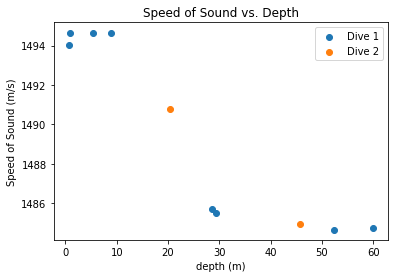

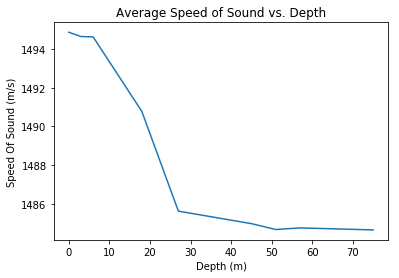

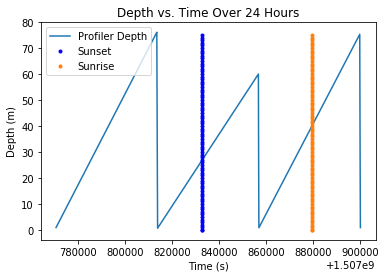

In [152]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSP/SP001/08-CTDPFJ000/recovered_cspp/ctdpf_j_cspp_instrument_recovered?beginDT=2017-10-12T19:03:46.000Z&endDT=2017-10-13T21:54:46.000Z&limit=1000&parameters=3,2,4,7"

#Profiler Specific Data Names
temperatureName = 'temperature'
pressureName = 'pressure'
salinityName = 'salinity'
timeName = 'time'

#Start Time
year = 2017
month = 10 
sunsetDay = 12 
sunsetHour = 18 
sunsetMinute = 26 
sunriseDay = 13
sunriseHour = 7
sunriseMinute = 25

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 2)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)       


## Oregon Shelf Surface Piercing Profiler Mooring - Winter

Number of Dives:  10


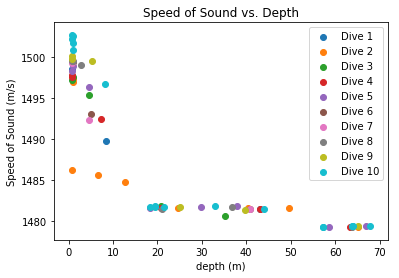

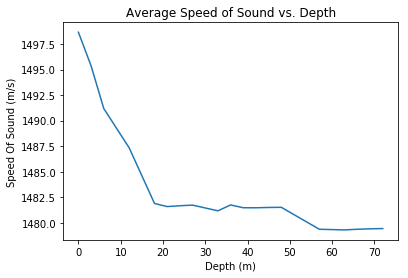

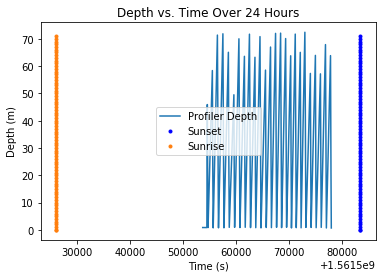

In [161]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSP/SP001/08-CTDPFJ000/recovered_cspp/ctdpf_j_cspp_instrument_recovered?beginDT=2019-06-26T19:54:46.000Z&endDT=2019-06-27T19:54:46.000Z&limit=1000&parameters=3,2,4,7"

temperatureName = 'temperature'
pressureName = 'pressure'
salinityName = 'salinity'
timeName = 'time'
year = 2019
month = 6 
sunsetDay = 26 
sunsetHour = 21 
sunsetMinute = 11 
sunriseDay = 26
sunriseHour = 5
sunriseMinute = 13

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 10)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)  

## Oregon Offshore Cabled Shallow Profiler Mooring - Winter

Number of Dives:  9


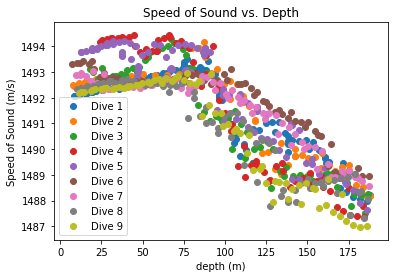

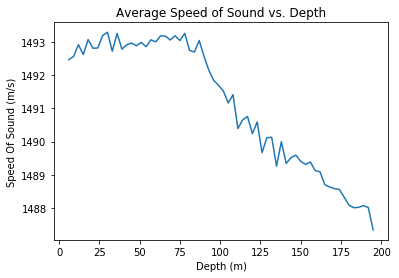

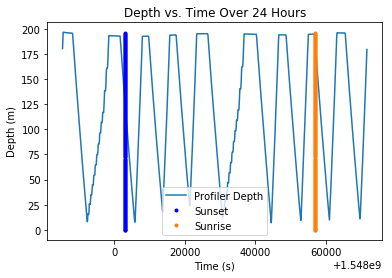

In [162]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPS/SF01B/2A-CTDPFA107/streamed/ctdpf_sbe43_sample?beginDT=2019-01-20T19:54:41.000Z&endDT=2019-01-21T19:54:41.000Z&limit=1000&parameters=13,908,7,909"

temperatureName = 'seawater_temperature'
pressureName = 'seawater_pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 1 
sunsetDay = 20 
sunsetHour = 16 
sunsetMinute = 52 
sunriseDay = 21
sunriseHour = 7
sunriseMinute = 48

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 9)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)  

## Oregon Offshore Cabled Shallow Profiler Mooring - Summer

Number of Dives:  9


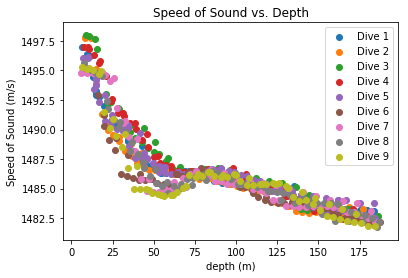

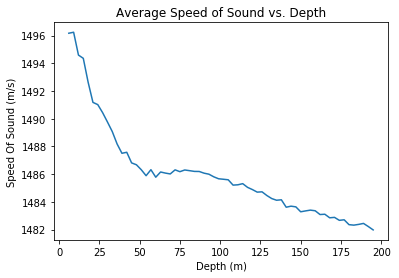

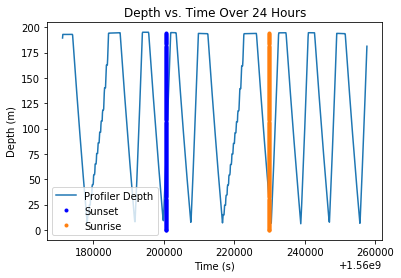

In [165]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPS/SF01B/2A-CTDPFA107/streamed/ctdpf_sbe43_sample?beginDT=2019-06-10T19:54:41.000Z&endDT=2019-06-11T19:54:41.000Z&limit=1000&parameters=13,909,908,7"

temperatureName = 'seawater_temperature'
pressureName = 'seawater_pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 6 
sunsetDay = 10 
sunsetHour = 21 
sunsetMinute = 6 
sunriseDay = 11
sunriseHour = 5
sunriseMinute = 11

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 9)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)  


## Oregon Offshore Cabled Deep Profiler Mooring - Winter

Number of Dives:  2


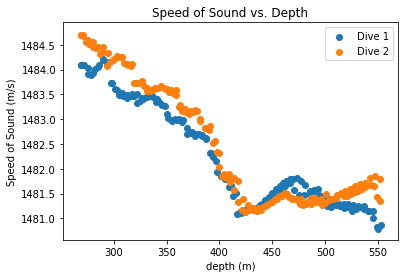

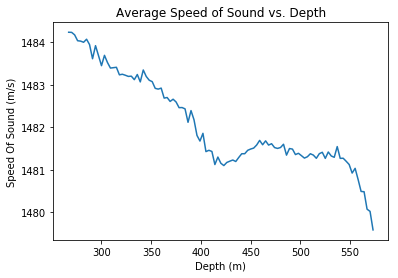

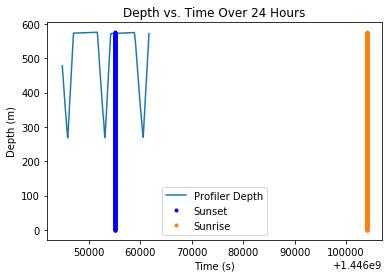

In [168]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPD/DP01B/01-CTDPFL105/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2015-10-28T22:07:54.000Z&endDT=2015-10-29T22:07:54.000Z&limit=1000&parameters=13,2,6,7"

temperatureName = 'temp'
pressureName = 'pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2015
month = 10
sunsetDay = 28 
sunsetHour = 17 
sunsetMinute = 58 
sunriseDay = 29
sunriseHour = 7
sunriseMinute = 33

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 2)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute) 


## Oregon Offshore Cabled Deep Profiler Mooring - Summer

Number of Dives:  12


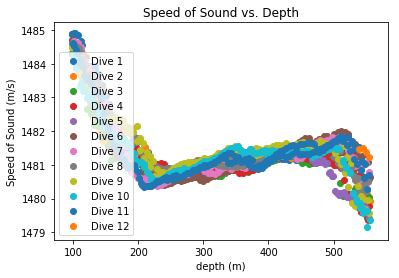

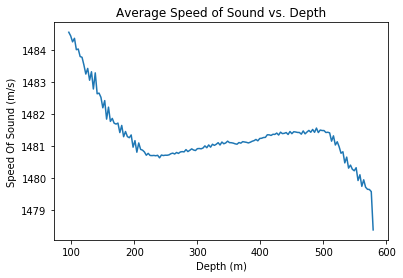

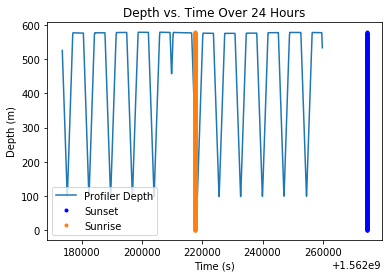

In [170]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPD/DP01B/01-CTDPFL105/recovered_wfp/dpc_ctd_instrument_recovered?beginDT=2019-07-04T00:04:46.000Z&endDT=2019-07-05T00:04:46.000Z&limit=1000&parameters=13,2,6,7"

temperatureName = 'temp'
pressureName = 'pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 7
sunsetDay = 4 
sunsetHour = 21 
sunsetMinute = 10 
sunriseDay = 4
sunriseHour = 5
sunriseMinute = 17

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 12)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute) 

## Oregon Slope Base Shallow Profiler - Winter

Number of Dives:  9


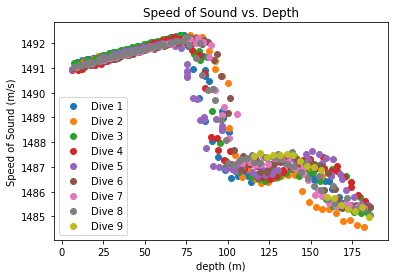

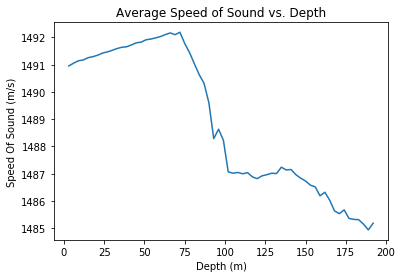

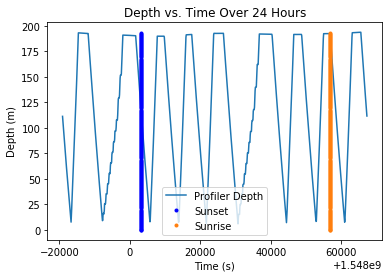

In [174]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPS/SF01A/2A-CTDPFA102/streamed/ctdpf_sbe43_sample?beginDT=2019-01-20T18:41:52.000Z&endDT=2019-01-21T18:41:52.000Z&limit=1000&parameters=13,909,908,7"

temperatureName = 'seawater_temperature'
pressureName = 'seawater_pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 1
sunsetDay = 20 
sunsetHour = 16 
sunsetMinute = 52 
sunriseDay = 21
sunriseHour = 7
sunriseMinute = 48

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 9)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute) 

## Oregon Slope Base Shallow Profiler - Summer

Number of Dives:  9


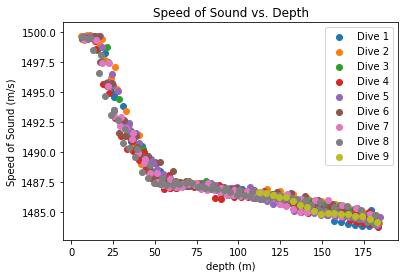

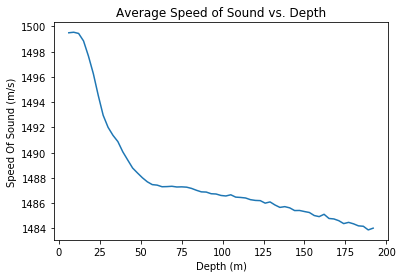

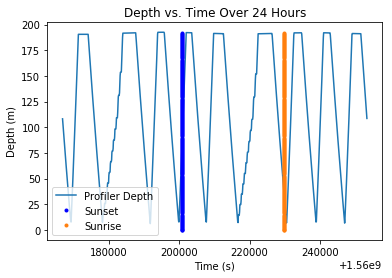

In [175]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPS/SF01A/2A-CTDPFA102/streamed/ctdpf_sbe43_sample?beginDT=2019-06-10T18:41:52.000Z&endDT=2019-06-11T18:41:52.000Z&limit=1000&parameters=13,909,908,7"

temperatureName = 'seawater_temperature'
pressureName = 'seawater_pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 6
sunsetDay = 10 
sunsetHour = 21 
sunsetMinute = 6 
sunriseDay = 11
sunriseHour = 5
sunriseMinute = 11

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 9)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute) 

## Oregon Slope Base Deep Profiler - Winter

Number of Dives:  2


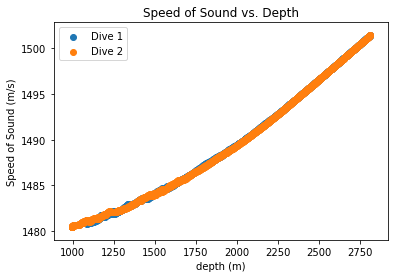

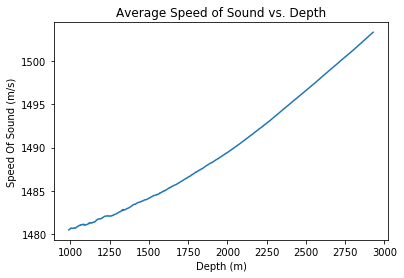

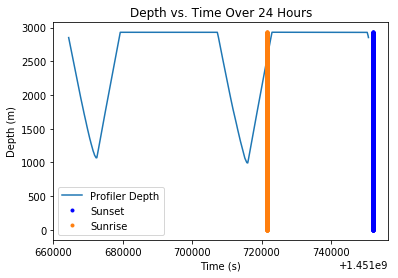

In [178]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPD/DP01A/01-CTDPFL104/recovered_wfp/dpc_ctd_instrument_recovered?beginDT=2016-01-02T00:07:00.000Z&endDT=2016-01-03T00:07:00.000Z&limit=1000&parameters=13,2,6,7"

temperatureName = 'temp'
pressureName = 'pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2016
month = 1
sunsetDay = 2 
sunsetHour = 16 
sunsetMinute = 29 
sunriseDay = 2
sunriseHour = 7
sunriseMinute = 58

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 2)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)

## Oregon Slope Base Deep Profiler - Summer

Number of Dives:  2


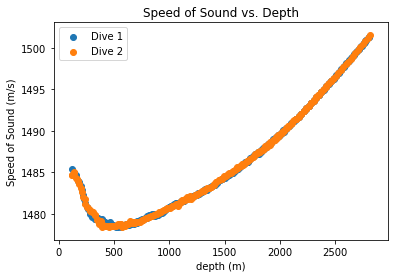

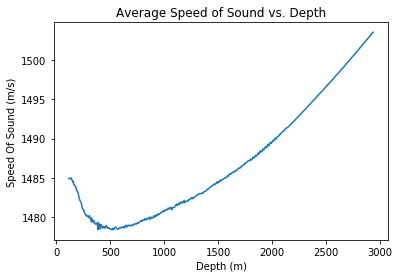

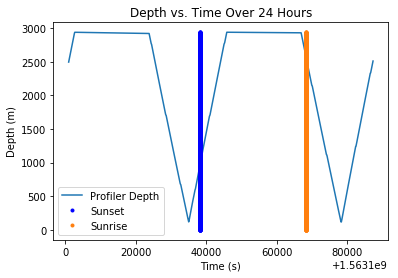

In [179]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPD/DP01A/01-CTDPFL104/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2019-07-14T17:42:10.000Z&endDT=2019-07-15T17:42:10.000Z&limit=1000&parameters=13,2,6,7"

temperatureName = 'temp'
pressureName = 'pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 7
sunsetDay = 14 
sunsetHour = 21 
sunsetMinute = 4 
sunriseDay = 15
sunriseHour = 5
sunriseMinute = 27

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 2)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)

## Axial Base Shallow Profiler - Winter

Number of Dives:  9


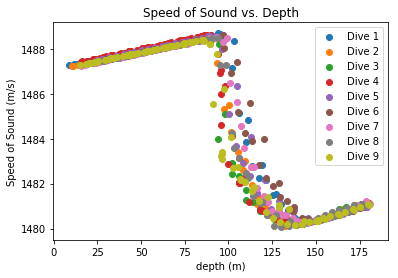

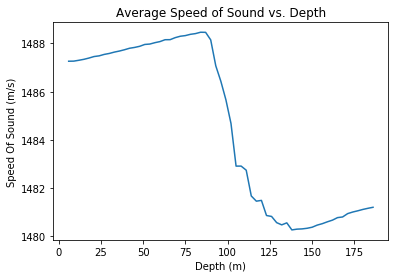

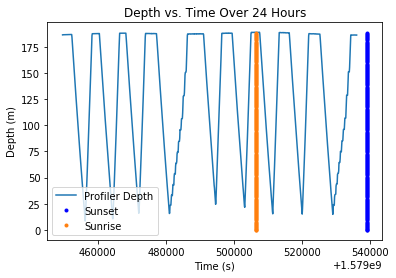

In [181]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPS/SF03A/2A-CTDPFA302/streamed/ctdpf_sbe43_sample?beginDT=2020-01-20T00:00:50.000Z&endDT=2020-01-21T00:00:50.000Z&limit=1000&parameters=13,909,908,7"

temperatureName = 'seawater_temperature'
pressureName = 'seawater_pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2020
month = 1
sunsetDay = 20 
sunsetHour = 16 
sunsetMinute = 51 
sunriseDay = 20
sunriseHour = 7
sunriseMinute = 49

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 9)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)


## Axial Base Shallow Profiler - Summer

Number of Dives:  9


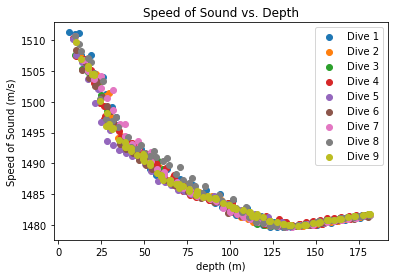

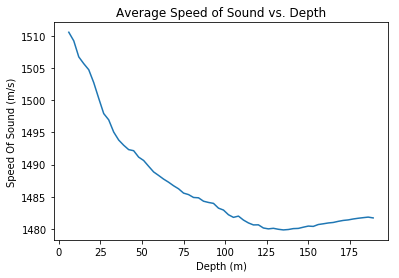

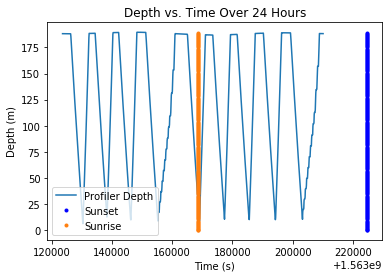

In [182]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPS/SF03A/2A-CTDPFA302/streamed/ctdpf_sbe43_sample?beginDT=2019-07-15T00:00:50.000Z&endDT=2019-07-16T00:00:50.000Z&limit=1000&parameters=13,909,908,7"

temperatureName = 'seawater_temperature'
pressureName = 'seawater_pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 7
sunsetDay = 15 
sunsetHour = 21 
sunsetMinute = 3 
sunriseDay = 15
sunriseHour = 5
sunriseMinute = 27

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 9)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)

## Axial Base Deep Profiler - Winter

Number of Dives:  2


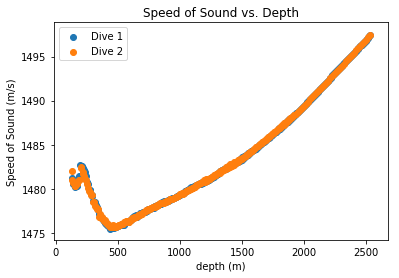

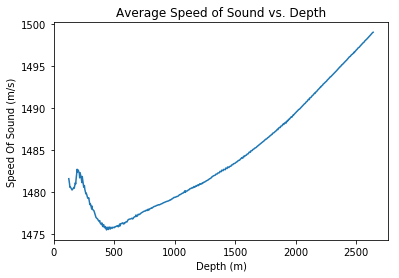

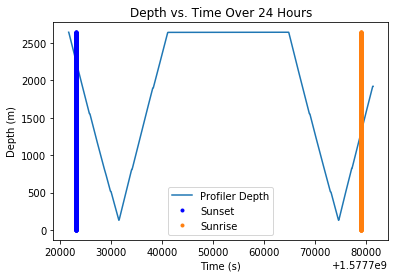

In [184]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPD/DP03A/01-CTDPFL304/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2019-12-30T19:32:36.000Z&endDT=2019-12-31T19:32:36.000Z&limit=1000&parameters=13,2,6,7"

temperatureName = 'temp'
pressureName = 'pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 12
sunsetDay = 30 
sunsetHour = 16 
sunsetMinute = 27 
sunriseDay = 31
sunriseHour = 7
sunriseMinute = 58

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 2)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)

## Axial Base Deep Profiler - Summer

Number of Dives:  2


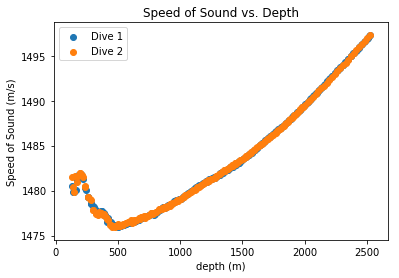

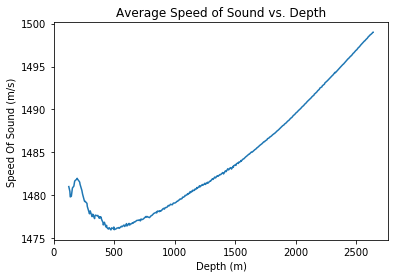

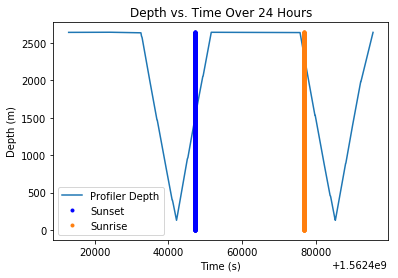

In [185]:
URL = "https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPD/DP03A/01-CTDPFL304/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2019-07-06T19:32:36.000Z&endDT=2019-07-07T19:32:36.000Z&limit=1000&parameters=13,2,6,7"

temperatureName = 'temp'
pressureName = 'pressure'
salinityName = 'practical_salinity'
timeName = 'time'
year = 2019
month = 7
sunsetDay = 6 
sunsetHour = 21 
sunsetMinute = 8 
sunriseDay = 7
sunriseHour = 5
sunriseMinute = 19

file = openURL(URL)

(salinity, time, temperature, depth) = getData(file, salinityName, timeName, temperatureName, pressureName)

print("Number of Dives: ", getNumberOfDives(depth))

DI = getDiveStartStop(depth)
ss = speedOfSound(temperature, salinity, depth)

plotSS(ss, depth, DI, 0, 2)

(avDepth, avSS) = averageSS(depth, ss)
plotAverageSS(avDepth, avSS)
    
plotDepthTime(time, depth, year, month, sunsetDay, sunsetHour, sunsetMinute, sunriseDay, sunriseHour, sunriseMinute)